Copyright (c) 2020. Cognitive Scale Inc. All rights reserved.
Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)




# Running Cortex Certifai Scan on Sklearn model built and deployed on AWS Sagemaker using Certifai Model Connectors


In this tutorial we will create sklearn models to classify german credit loan risk (predict whether loan will be granted or not). Models are built using Scikit-learn with [Sagemaker](https://sagemaker.readthedocs.io/en/stable/using_sklearn.html) by utilizing the pre-built container. Cortex Certifai provides first class support for various machine learning platforms including aws-sagemaker. We will then use [Cortex Certifai Toolkit](https://www.cognitivescale.com/download-certifai/) to launch fairness evaluation on the hosted models

### Prerequisites

This notebook was created and tested on an ml.m4.xlarge sagemaker notebook instance. However you can also run it locally by making sure you have the [aws profile](https://docs.aws.amazon.com/cli/latest/reference/configure/) configured and following dependencies installed on your system


- python>=3.6.2,<=3.7
- scikit-learn==0.23.1
- numpy==1.18.1
- pandas
- sagemaker==1.58.2
- boto3 >= 1.0.0,< 2.0.0
- ipython
- matplotlib
- jupyter
- [optional for configuring aws profile] awscli==1.18.61
- wget (when running locally on mac/windows)
- certifai_toolkit>=1.12.14

> **Please note**: this tutorial assumes you have downloaded the [Cortex Certifai Toolkit](https://www.cognitivescale.com/download-certifai/) and uploaded it to your `S3` bucket which will be later used to install certifai packages.
> Also make sure you have configured aws with right roles and region for using S3 bucket and sagemaker utilities.

### First, lets create our Sagemaker session and role and create a S3 prefix to use for the notebook example.


#### [optional for local uage] sagemaker iam role guide setting up permissions (roles) for running this notebook locally
- follow the [sagemaker-iam-role-documentation](https://docs.aws.amazon.com/glue/latest/dg/create-an-iam-role-sagemaker-notebook.html) for creating an `iam-role`

> this notebook was built using iam-role `AmazonSageMakerFullAccess`

make sure `~/.aws/configure` looks like below


```
[default]
region = <aws-region>
output = <YAML>
role_arn = <aws_iam_role>
source_profile = default
```
and `~/.aws/credentials` has the necessary access and secret access keys

```
[default]
aws_access_key_id = <access_key_id>
aws_secret_access_key = <secret_access_key>
```

**PleaseNote**:  Once you have the execution role setup (using iam-role guide from above), you must enable `Trust Policy` which specifies who is allowed to assume the associated role. If this is missing you might get an **error 
user <user1\> unable to  STS AssumeRole**. Refer to [trust-policy-iam-role](https://aws.amazon.com/blogs/security/how-to-use-a-single-iam-user-to-easily-access-all-your-accounts-by-using-the-aws-cli/)

### Install Scikit-Learn

In [1]:
!pip install scikit-learn==0.23.1

In [2]:
# S3 prefix
prefix = 'german-credit-certifai'

import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.(set role in ~/.aws/config when running locally)
role = get_execution_role()

### Download german credit dataset from UCI 

- on macOS wget can be installed via homebrew `brew install wget`
- on windows download wget from [here](http://gnuwin32.sourceforge.net/packages/wget.htm)

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data -O german_credit.csv

--2020-11-26 17:08:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german_credit.csv’

german_credit.csv   100%[===================>]  77.92K   154KB/s    in 0.5s    

2020-11-26 17:08:50 (154 KB/s) - ‘german_credit.csv’ saved [79793/79793]



### Convert downloaded raw dataset to encoded csv

In [4]:
from decode_data import make_decoded_data
!mkdir -p ./data
make_decoded_data("data/german_credit-decoded.csv")

saving decoded data as data/german_credit-decoded.csv




### Test to confirm correct version of scikit-learn and numpy are installed


In [5]:
import sklearn as sklearn_version_test
import numpy as numpy_version_test
assert sklearn_version_test.__version__ == '0.23.1', 'scikit-learn version mismatch, `!pip install scikit-learn==0.22.1` paste this command in a cell to install right sklearn version for this notebook'
assert numpy_version_test.__version__   == '1.18.1', 'numpy version mismatch, `!pip install numpy==1.18.1` paste this command in a cell to install right numpy version for this notebook'

### Upload the encoded dataset to S3 for training 

In [6]:
WORK_DIRECTORY = 'data'
train_input = sagemaker_session.upload_data(WORK_DIRECTORY, key_prefix="{}/{}".format(prefix, WORK_DIRECTORY) )

### Create a Scikit-learn script to train with 

SageMaker can run a scikit-learn script using the SKLearn estimator. When executed on SageMaker a number of environment variables are available to access properties of the training environment, such as:

- SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. Any artifacts saved in this folder are uploaded to S3 for model hosting after the training job completes.
-  SM_OUTPUT_DIR: A string representing the filesystem path to write output artifacts to. Output artifacts may include checkpoints, graphs, and other files to save, not including model artifacts. These artifacts are compressed and uploaded to S3 to the same S3 prefix as the model artifacts.

Supposing two input channels, 'train' and 'test', were used in the call to the SKLearn estimator's fit() method, the following environment variables will be set, following the format SM_CHANNEL_[channel_name]:

    SM_CHANNEL_TRAIN: A string representing the path to the directory containing data in the 'train' channel
    SM_CHANNEL_TEST: Same as above, but for the 'test' channel.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to script as arguments and can be retrieved with an argparse.ArgumentParser instance. For example, the script that we will run in this notebook is the below:

### Create encoder for the encoding categorical features

Note all extra modules and files must be in a directory to be uploaded to sagemaker. We create a directory name `source_dir` and add our files

In [7]:
!mkdir -p source_dir

In [8]:
%%writefile source_dir/cat_encoder.py

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np

class CatEncoder:
    def __init__(self, cat_columns, data, normalize: bool=True):
        self.cat_indexes = [data.columns.get_loc(name) for name in cat_columns]
        self.num_indexes = [idx for idx in range(len(data.columns)) if idx not in self.cat_indexes]
        self.encoder = preprocessing.OneHotEncoder()
        self.encoder.fit(data[cat_columns])
        self.num_columns = list(data.columns[self.num_indexes])
        self.cat_columns = cat_columns
        cat_transformed_names = self.encoder.get_feature_names(input_features=self.cat_columns)
        self._transformed_column_names =  self.num_columns + list(cat_transformed_names)
        if normalize:
            self.normalizer = StandardScaler()
            self.normalizer.fit(data.iloc[:, self.num_indexes])
        else:
            self.normalizer = None

    def __call__(self, x):
        numeric = x[:, self.num_indexes]
        if self.normalizer is not None:
            numeric = self.normalizer.transform(numeric)
        categorical = self.encoder.transform(x[:, self.cat_indexes]).toarray()
        return np.concatenate((numeric, categorical), axis=1)

    @property
    def transformed_features(self):
        return self._transformed_column_names


Writing source_dir/cat_encoder.py


### Create requirements.txt file for any training/inference specific python packages/versions

In [9]:
%%writefile source_dir/requirements.txt
scikit-learn==0.22.1
numpy==1.18.1

Writing source_dir/requirements.txt


### Create logistic model training and inference script

In [10]:
%%writefile source_dir/logistic_script.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import joblib
import numpy as np
from cat_encoder import CatEncoder
import json

# inference functions ---------------
def model_fn(model_dir):
    print(f'listing model dir {os.listdir(model_dir)}' )
    clf = joblib.load(os.path.join(model_dir,'german_credit_logit.joblib'))
    print(clf)
    return clf


def input_fn(request_body, request_content_type):
    """An input_fn that loads a json bytes string. 
    Certifai invokes model with the json schema -> {"payload": {"instances": [ [6,107,88,0,0,36.8,0.727,31], [5,100,80,0,0,31.9,0.61,33] ]}}
    """
    if request_content_type == "application/json":
        input_data  = json.loads(request_body).get('payload', {}).get('instances', [])
        data  = np.array(input_data, dtype=object)
        data  = data if data.ndim == 2 else np.reshape(data, (1, -1))
        return data
    else:
        raise Exception(f'content type {request_content_type} not supported')

def predict_fn(input_data, clf):
    """certifai expects model response with json
    schema -> {"payload": {"predictions": [1,0]} }
    """
    model = clf.get('model')
    encoder = clf.get('encoder')
    try:
        prediction = model.predict(encoder(input_data))
        print(prediction)
        return {"payload":{ "predictions": prediction.tolist()} }
    except Exception as e:
        return {"payload":{ "error": str(e)}}
                


if __name__ =='__main__':
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--train-file', type=str, default='german_credit-decoded.csv')
    
    # hyperparams for training
    parser.add_argument('--max_iter', type=list,  default=[1000])
    parser.add_argument('--solver',   type=list,  default= ['lbfgs'])
    parser.add_argument('--C',        type=tuple, default=(0.5, 1.0, 2.0))

    args, _ = parser.parse_known_args()    
    
    print('reading data')
    df = pd.read_csv(os.path.join(args.train, args.train_file))
    cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

    label_column = 'outcome'
    y = df[label_column]
    X = df.drop(label_column, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # apply categorical encoder to data     
    encoder = CatEncoder(cat_columns, X)
    
    parameters = {'C':args.C, 'solver':args.solver, 'max_iter':args.max_iter}
    
    m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(encoder(X_train.values), y_train)

    # Assess on the test data
    accuracy = model.score(encoder(X_test.values), y_test)
    print(f"Model accuracy is {accuracy}")
  
    # create artifact object with model and encoder
    model_path = os.path.join(args.model_dir, 'german_credit_logit')
    model_path = f'{model_path}.joblib'
    model_obj = {
        "model":model,
        "encoder":encoder
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model {model_obj} saved on disk as {model_path}')


Writing source_dir/logistic_script.py


### training logistic model locally

In [11]:
! python source_dir/logistic_script.py --model-dir ./ \
                   --train ./data \

extracting arguments
reading data
Model accuracy is 0.805
model {'model': GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': (0.5, 1.0, 2.0), 'max_iter': [1000],
                         'solver': ['lbfgs']}), 'encoder': <cat_encoder.CatEncoder object at 0x112a9dda0>} saved on disk as ./german_credit_logit.joblib


### Create SageMaker Scikit Estimator for logistic model

To run our Scikit-learn training script on SageMaker, we construct a sagemaker.sklearn.estimator.sklearn estimator, which accepts several constructor arguments:

-    entry_point: The path to the Python script SageMaker runs for training and prediction.
-    role: Role ARN
-    train_instance_type (optional): The type of SageMaker instances for training. Note: Because Scikit-learn does not natively support GPU training, Sagemaker Scikit-learn does not currently support training on GPU instance types.
-    sagemaker_session (optional): The session used to train on Sagemaker.
-    hyperparameters (optional): A dictionary passed to the train function as hyperparameters.


In [13]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_logistic = SKLearn(
    entry_point='logistic_script.py',
    framework_version="0.23-1",
    py_version="py3",
    source_dir='source_dir',
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
    )


### Train SKLearn logistic model Estimator on german credit encoded data uploaded to S3
Training is very simple, just call fit on the Estimator. This will start a SageMaker Training job that will download the data for us, invoke our scikit-learn code (in the provided script file inside the source_dir), and save any model artifacts that the script creates.

In [14]:
sklearn_logistic.fit({'train': train_input})

2020-11-26 11:40:13 Starting - Starting the training job...
2020-11-26 11:40:15 Starting - Launching requested ML instances...
2020-11-26 11:41:21 Starting - Preparing the instances for training......
2020-11-26 11:42:09 Downloading - Downloading input data...
2020-11-26 11:43:01 Training - Training image download completed. Training in progress..2020-11-26 11:43:01,272 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-11-26 11:43:01,274 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-26 11:43:01,283 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-11-26 11:43:01,657 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attemptin

### Similarly create svm model training and inference script

In [15]:
%%writefile source_dir/svm_script.py

import argparse
import os
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
import joblib
import numpy as np
from cat_encoder import CatEncoder
import json

# inference functions ---------------
def model_fn(model_dir):
    print(f'listing model dir {os.listdir(model_dir)}' )
    clf = joblib.load(os.path.join(model_dir,'german_credit_svm.joblib'))
    print(clf)
    return clf


def input_fn(request_body, request_content_type):
    """An input_fn that loads a json bytes string"""
    if request_content_type == "application/json":
        input_data  = json.loads(request_body).get('payload', {}).get('instances', [])
        data  = np.array(input_data, dtype=object)
        data  = data if data.ndim == 2 else np.reshape(data, (1, -1))
        return data
    else:
        raise Exception(f'content type {request_content_type} not supported')

def predict_fn(input_data, clf):
    model = clf.get('model')
    encoder = clf.get('encoder')
    try:
        prediction = model.predict(encoder(input_data))
        print(prediction)
        return {"payload":{ "predictions": prediction.tolist()} }
    except Exception as e:
        return {"payload":{ "error": str(e)}}
                


if __name__ =='__main__':
    print('extracting arguments')
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    parser.add_argument('--model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--train-file', type=str, default='german_credit-decoded.csv')
    
    # hyperparams for training
    parser.add_argument('--kernel', type=list,  default= ['linear', 'rbf', 'poly'])
    parser.add_argument('--gamma',  type=list,  default= ['auto'])
    parser.add_argument('--C',      type=list,  default= [0.1, .5, 1, 2, 4, 10])

    args, _ = parser.parse_known_args()    
    
    print('reading data')
    df = pd.read_csv(os.path.join(args.train, args.train_file))
    cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

    label_column = 'outcome'
    y = df[label_column]
    X = df.drop(label_column, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    
    # apply categorical encoder to data     
    encoder = CatEncoder(cat_columns, X)
        
    parameters={'kernel':args.kernel, 'C':args.C, 'gamma':args.gamma}
    m = svm.SVC()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(encoder(X_train.values), y_train)

    # Assess on the test data
    accuracy = model.score(encoder(X_test.values), y_test)
    print(f"Model accuracy is {accuracy}")
  
    # create artifact object with model and encoder
    model_path = os.path.join(args.model_dir, 'german_credit_svm')
    model_path = f'{model_path}.joblib'
    model_obj = {
        "model":model,
        "encoder":encoder
    }
    joblib.dump(value=model_obj, filename=model_path)
    print(f'model {model_obj} saved on disk as {model_path}')


Writing source_dir/svm_script.py


### training svm model locally

In [16]:
! python source_dir/svm_script.py --model-dir ./ \
                   --train ./data 

extracting arguments
reading data
Model accuracy is 0.81
model {'model': GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 2, 4, 10], 'gamma': ['auto'],
                         'kernel': ['linear', 'rbf', 'poly']}), 'encoder': <cat_encoder.CatEncoder object at 0x113b26ef0>} saved on disk as ./german_credit_svm.joblib


### Similarly create SageMaker Scikit Estimator for svm model

In [18]:
from sagemaker.sklearn.estimator import SKLearn

sklearn_svm = SKLearn(
    entry_point='svm_script.py',
    framework_version="0.23-1",
    py_version="py3",
    source_dir='source_dir',
    train_instance_type="ml.c4.xlarge",
    role=role,
    sagemaker_session=sagemaker_session
    )


### Train SKLearn svm model Estimator on german credit encoded data uploaded to S3


In [19]:
sklearn_svm.fit({'train': train_input})

2020-11-26 11:49:50 Starting - Starting the training job...
2020-11-26 11:49:52 Starting - Launching requested ML instances...
2020-11-26 11:50:56 Starting - Preparing the instances for training......
2020-11-26 11:52:01 Downloading - Downloading input data...
2020-11-26 11:52:25 Training - Downloading the training image..2020-11-26 11:52:45,581 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-11-26 11:52:45,583 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-11-26 11:52:45,592 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-11-26 11:52:45,972 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: scikit-learn

### Using the trained model to make inference requests 

### Deploy the models

**Note:** this might take a few minutes

In [20]:
predictor_logistic = sklearn_logistic.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

------------!

In [21]:
predictor_svm      = sklearn_svm.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

-------------!

### Test model predictions

In [22]:
import numpy as np
import json
idata = json.dumps({"payload":{
    "instances":[
            "... < 0 DM",
            6,
            "critical account/ other credits existing (not at this bank)",
            "radio/television",
            1169,
            "unknown/ no savings account",
            ".. >= 7 years",
            4,
            "male : single",
            "others - none",
            4,
            "real estate",
            "> 25 years",
            "none",
            "own",
            2,
            "skilled employee / official",
            1,
            "phone - yes, registered under the customers name",
            "foreign - yes"
        ]}})

import boto3
import botocore
import json
from botocore.exceptions import HTTPClientError
client=boto3.client('sagemaker-runtime')
try:
    resp = client.invoke_endpoint(EndpointName=predictor_logistic.endpoint,Body=idata)
    print(json.loads(resp['Body'].read()))
except botocore.exceptions.ClientError as error:
    print(error)

{'payload': {'predictions': [1]}}


### Set Cortex Certifai Toolkit path

- [optional] update the `certifai_toolkit_path` to a local file path where the downloaded toolkit from S3 bucket will be saved
- this will be used in the next cell to install cortex certifai python packages


### Download toolkit from S3 bucket to current environment

In [23]:
import os
from os.path import expanduser
home = expanduser('~')
certifai_toolkit = 'certifai_toolkit.zip'
s3 = boto3.client('s3')
s3.download_file('S3_BUCKET_NAME', 'S3_OBJECT_NAME', certifai_toolkit)

### unzip and extract cortex_certifai_toolkit

In [24]:
!rm -rf certifai_toolkit
!unzip -q -d certifai_toolkit $certifai_toolkit
!cat certifai_toolkit/version.txt

Certifai Version: 1.3.5
Scanner build: 1.3.5-81-gec04b930
Console build: 1.3.5-149-ge576d67
Reference Models build: 1.3.5-8-g5965926


### Install required certifai packages (optional packages are left for user to install)¶

initiating a Cortex Certifai scan requires following python packages to be installed in the current local environment. We will be using `cortex-certifai-connectors` package which provided first class support for sagemaker models

required-packages

-    cortex-certifai-scanner
-    cortex-certifai-engine
-    cortex-certifai-common
-    cortex-certifai-connectors

optional-packages

-   cortex-certifai-client
-   cortex-certifai-console

**NOTE:** Make sure to install `cortex-certifai-engine` package for correct python version, by default it will install for `$certifai_toolkitpackages/python3.6` in the cell below. python 3.6/7/8 are supported

In [25]:
!find certifai_toolkit/packages/all       -type f ! -name "*console-*" | xargs -I % sh -c 'pip install % ' ;
!find certifai_toolkit/packages/python3.6 -type f   -name "*engine-*"                      | xargs -I % sh -c 'pip install % ' ;

Processing ./certifai_toolkit/packages/all/cortex-certifai-model-sdk-1.3.5-81-gec04b930.zip
     |████████████████████████████████| 94 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 298 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 46.3 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 60 kB 12.9 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 204 kB 2.6 MB/s eta 0:00:01
  Created wheel for cortex-certifai-model-sdk: filename=cortex_certifai_model_sdk-1.3.5-py3-none-any.whl size=10045 sha256=2acb30e294456630ae95163db54361115d6cf00368dfe54d37e33b8ff85f9073
  Stored in directory: /Users/administrator/Library/Caches/pip/wheels/1b/5e/76/8ac597dc84d88368cadbdcbd9dc82262892336349cbc54db82
  Created wheel for greenlet: filename=green

  Created wheel for cortex-certifai-connectors: filename=cortex_certifai_connectors-1.3.5-py3-none-any.whl size=14694 sha256=38f8b9f979e1fe5147f09bc742d3c83bd5f8852af09ed0d6950c4933ba5640e7
  Stored in directory: /Users/administrator/Library/Caches/pip/wheels/9d/a0/65/dbd3044c2f62001d97c0ccfe352d517ad5d8a372bcc60f4f30
Successfully built cortex-certifai-connectors
  Attempting uninstall: botocore
    Found existing installation: botocore 1.16.11
    Uninstalling botocore-1.16.11:
      Successfully uninstalled botocore-1.16.11
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

awscli 1.18.61 requires botocore==1.16.11, but you'll have botocore 1.19.25 which is incompatible.
Processing ./certifai_toolkit/packages/all/cortex-certifai-client-1.3.5-81

  Created wheel for cortex-certifai-common: filename=cortex_certifai_common-1.3.5-py3-none-any.whl size=81433 sha256=b731a3c8ce72e92506959b7f4915447505cebd3a8f5aaa18de097c9cd6db6cfc
  Stored in directory: /Users/administrator/Library/Caches/pip/wheels/26/ea/ca/3175a343819517882405eec621c165dd6f9e8bd858ff838a79
Successfully built cortex-certifai-common
Processing ./certifai_toolkit/packages/all/cortex-certifai-policy-1.3.5-81-gec04b930.zip
  Created wheel for cortex-certifai-policy: filename=cortex_certifai_policy-1.3.5-py3-none-any.whl size=17207 sha256=ba7cd714c139f33c423e872a867f55ca81aebf02cf8a0c431aed8558880a5c71
  Stored in directory: /Users/administrator/Library/Caches/pip/wheels/ea/a9/d2/90716aaaa713e5795f4a77f96759cca1f8329a48678a8f0da7
Successfully built cortex-certifai-policy
Processing ./certifai_toolkit/packages/python3.6/cortex-certifai-engine-1.3.5-81-gec04b930-py3.6.12.zip
     |████████████████████████████████| 47 kB 2.2 MB/s eta 0:00:011
     |█████████████████████████

### Using Cortex Certifai python-package to launch a scan


In [26]:
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiModelConnector, CertifaiModelMetric)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
import pandas as pd


### define cortex certifai task type

-    CertifaiTaskOutcomes : cortex certifai supports classification as well as regression models. here we have an example of binary-classification (e.g. predict whether loan should be granted or not)
-    CertifaiOutcomeValue : define the different outcomes possible from the model predictions. here we have a model that predicts either 1(loan granted) or 2(loan denied)

Note: Please refer to [Certifai Api Docs](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref/certifai.scanner.builder.html) for more details


In [27]:
base_path = '.'
all_data_file = f"{base_path}/data/german_credit-decoded.csv"

In [28]:
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_user_case',
                                  prediction_task=task)


### add logistic and svm models sagemaker models deployed above


In [29]:
# Add the SageMaker model
sagemaker_connector = CertifaiModelConnector('sagemaker', 'certifai.connectors.sagemaker', 'SageMakerModel')
first_model = CertifaiModel('logit_sagemaker',
                            predict_endpoint=predictor_logistic.endpoint,
                            connector=sagemaker_connector)
scan.add_model(first_model)
second_model = CertifaiModel('svm_sagemaker',
                            predict_endpoint=predictor_svm.endpoint,
                            connector=sagemaker_connector)
scan.add_model(second_model)


### add the evaluation dataset to scan object

-    evaluation dataset dataset to be used by cortex certifai to evaluate the model against



In [30]:
# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(all_data_file))
scan.add_dataset(eval_dataset)

### evaluating model fairness

-   add fairness as evaluation type to scan object
-   create an evaluation_dataset_id to refer to added evaluation datset

In [31]:

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'

In [32]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = 'outcome'

In [33]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = scan.run(write_reports=False)

2020-11-26 17:40:29,696 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


Starting scan with model_use_case_id: 'test_user_case' and scan_id: 'd41307abb85f'
[--------------------] 2020-11-26 17:40:29.688426 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: logit_sagemaker


2020-11-26 17:42:17,303 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2020-11-26 17:43:02,779 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2020-11-26 17:45:23,024 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-11-26 17:46:20,855 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 1000 samples
2020-11-26 17:46:20,856 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 548 samples
2020-11-26 17:46:30,124 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 50 samples)


[##########----------] 2020-11-26 17:46:30.117053 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: svm_sagemaker


2020-11-26 17:48:50,467 root   WARNING  Examples of protected class ('status', 'male : divorced/separated') exhausted before convergence after 50 samples
2020-11-26 17:49:59,947 root   WARNING  Examples of protected class ('status', 'male : married/widowed') exhausted before convergence after 92 samples
2020-11-26 17:53:41,922 root   WARNING  Examples of protected class ('status', 'female : divorced/separated/married') exhausted before convergence after 310 samples
2020-11-26 17:54:50,528 root   WARNING  Examples of protected class ('age', '> 25 years') exhausted before convergence after 999 samples
2020-11-26 17:54:50,529 root   WARNING  Examples of protected class ('status', 'male : single') exhausted before convergence after 547 samples


[####################] 2020-11-26 17:54:59.683886 - 2 of 2 reports (100.0% complete) - Completed all evaluations



### Analayze Fairness Results


In [34]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
df = construct_scores_dataframe(scores('fairness', result), include_confidence=False)
display(df)

,context,type,overall fairness,Feature (age),Group details (> 25 years),Feature (status),Group details (female : divorced/separated/married),Group details (male : divorced/separated),Group details (male : married/widowed),Group details (male : single)
logit_sagemaker (burden),logit_sagemaker,burden,74.918814,100.0,0.048185,74.918814,0.068202,0.070117,0.032206,0.037323
svm_sagemaker (burden),svm_sagemaker,burden,75.660392,100.0,0.048989,75.660392,0.064648,0.071231,0.030885,0.041159



### fairness by model


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (> 25 years),Group details (> 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
logit_sagemaker (burden),logit_sagemaker,burden,74.918814,65.153574,83.369134,100.0,100.0,100.0,0.048185,0.042871,...,0.079074,0.070117,0.045978,0.096528,0.032206,0.020428,0.045656,0.037323,0.031083,0.044004
svm_sagemaker (burden),svm_sagemaker,burden,75.660392,64.796499,85.119045,100.0,100.0,100.0,0.048989,0.043974,...,0.075285,0.071231,0.046415,0.098047,0.030885,0.018627,0.043628,0.041159,0.034638,0.048163


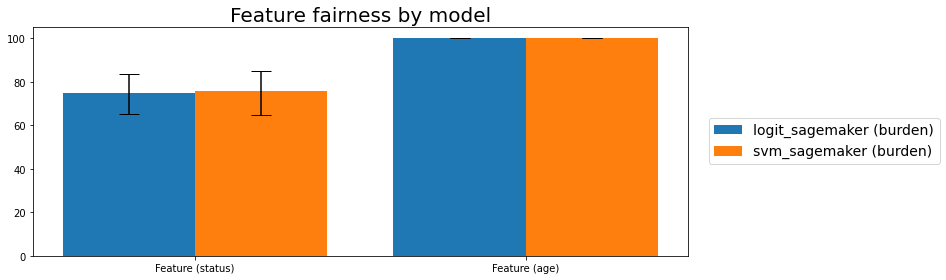

In [35]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))
display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

### Endpoint cleanup

delete the containers created after evaluation is complete

In [36]:
sklearn_svm.delete_endpoint()
sklearn_logistic.delete_endpoint()